# Exercise 1 (100%)

請利用`ig5000.csv`建立一個deep learning sequence-based model分類廣告與非廣告po文。
- 'label'欄位中，`0`指一般日常po文，`1`指廣告po文
- Sequence model的部分你可以任意選擇你熟悉或喜歡的架構:SimpleRNN, LSTM, etc.
- 你可以試著在embedding layer的部分套用pretrained word embeddings加強訓練效果
- **模型架構方面，除了語言表徵之外，請衍生另外兩個feature: 文本長度(text length)及詞彙豐富度(lexical diversity)，並將此兩項額外feature與語言表徵合併進行模型訓練** [註1]
- 如果包含兩個額外feature的model做不出來，只做文本表徵部分即可

============

[註1]
- 文本長度即**N(token)**
- 詞彙豐富度指一篇po文中**N(type)/N(token)的值** ('我 覺得 我 很 棒'=> 4/5 = 0.8)
- 兩項info data需要normalize

============

最後你的output至少需要包含：
1. 訓練corpus(包含資訊見範例輸出) (20%)
2. 你的model架構 (30%)
3. Model training log (30%)
4. Evaluation plot (20%)

# Build Corpus

## Import Packages and Files

In [1]:
import pandas as pd
import re
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
! pip3 install -U ckip-transformers
from ckip_transformers.nlp import CkipWordSegmenter
import numpy as np

     |████████████████████████████████| 3.1 MB 8.0 MB/s 
     |████████████████████████████████| 596 kB 41.8 MB/s 
     |████████████████████████████████| 895 kB 36.0 MB/s 
     |████████████████████████████████| 3.3 MB 29.5 MB/s 
     |████████████████████████████████| 59 kB 6.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
from google.colab import drive
drive.mount('/content/drive')

!wget -P /content/drive/MyDrive/NTU_Studies/2021_Fall

Mounted at /content/drive
wget: missing URL
Usage: wget [OPTION]... [URL]...

Try `wget --help' for more options.


## Load and Clean Text File

In [3]:
ig5000 = '/content/drive/MyDrive/NTU_Studies/2021_Fall/assignment-3-tanlianhui/ig5000.csv'

ig = pd.read_csv(ig5000).dropna()
ig

,text,label
0,V領設計能夠修飾臉型😍\n減齡泡泡袖洋裝😉\n👉https://lihi1.com/JDym...,1
1,【20210303】\n能勇敢追夢的人\n身上都閃著和煦的光芒\n也是好生羨慕！\n-\n敬...,0
2,玉 耳環\n#耳環 #玉 #earrings,1
3,【美國瘋潮WWE Taiwan】\n不管是WWE Elite還是AEW Unrivaled系...,1
4,🌈\n尋晚的post 一po已經被秒殺好多件的Vintage sports windbrea...,1
...,...,...
4995,🌈長桿34cm綠瑪瑙煙嘴煙斗\n復古長桿煙斗\塞入菸草即可使用\n162028\001390,1
4996,抗敏之選*Eunice 藍甘菊舒緩潔面乳~1000ml \n\n★好多美容院都用佢★\n\n...,1
4997,今天特地比較慢出門\n但還是太早到學校了🤦🏼‍♀️\n可能下雨關係車好多今天,1
4998,大量韓國新貨上架🌸\n歡迎到門市選購\n-\n🟥🔺🔶🟧🔸🟡🟨🟩🟢🔹🔷🟦🟣🟪\n———————...,1


In [4]:
# word segmentation
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^\u4E00-\u9FD5]"

def clean(texts, clean_re):
    output = []
    for text in texts:
        text = re.sub(clean_re, '', text)
        output.append(text)
    return output

def tokenize(texts, driver, batch_size, max_length):
    output=[]
    ws  = driver(texts, use_delim=False, 
                batch_size = batch_size,
                 max_length = max_length
                    )
    output = [" ".join(ls) for ls in ws]
    return output

ws_driver = CkipWordSegmenter(device = 0, level = 3)
ig_cleaned = clean(ig['text'].to_list(), text_cleaning_re)
ig_segmented = tokenize(ig_cleaned, ws_driver, 512, 250)
# ig_segmented[:10]

Downloading:   0%|          | 0.00/804 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/388M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/107k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/301 [00:00<?, ?B/s]

Inference: 100%|██████████| 11/11 [02:37<00:00, 14.34s/it]


## Calculate and Normalize Sentence Length and Diversity 

In [5]:
# normalize 
import math

def sigmoid(x):
    sig = 1 / (1 + math.exp(-x/50))
    return sig

len_ls = []
for i in ig_segmented:
  # count text length
  len_ls.append(sigmoid(len(i)))

print(len_ls)

[0.6637386974043528, 0.8234647252208833, 0.5448788923735801, 0.9772460565371959, 0.9827068434300946, 0.6726070170677604, 0.9931728675778617, 0.8175744761936437, 0.6592603884513855, 0.8889440332885924, 0.9683237716209436, 0.8506870654691563, 0.9600746660471863, 0.6681877721681662, 0.998437649049671, 0.7576796390037048, 0.8889440332885924, 0.5646362918030292, 0.9137258055040833, 0.7349725994665188, 0.9447994622170657, 0.9577102281579662, 0.6364525402815664, 0.9999999586006244, 0.9997308573923388, 0.9793667027730938, 0.9227277978633401, 0.7068222210935676, 0.8698915256370021, 0.5049998333399998, 0.9227277978633401, 0.86056612703835, 0.9999029318329203, 0.9878715650157257, 0.9951310687562414, 0.7649478037637647, 0.7068222210935676, 0.9268988265776218, 0.8629487074245404, 0.9623121094913941, 0.8375349374193038, 0.6813537337890256, 0.6082590307465143, 0.52497918747894, 0.5890404340586651, 0.9999983911671968, 0.8928319295134719, 0.7924899414403644, 0.617747874769249, 0.7755640142690734, 0.850

In [6]:
# lexical diversity, i.e. N(type)/N(token)
def lexdiv(x):
  ls = []
  for i in x:
    ls.append(i)
  if len(ls) != 0:
    lexical_diversity = len(set(ls)) / len(ls)
    return lexical_diversity
  else:
    return 0

# append in div_ls
div_ls = []
for i in ig_segmented:
  # count text length 
  div_ls.append(lexdiv(i))

print(div_ls)

[0.5588235294117647, 0.4805194805194805, 0.4444444444444444, 0.4148936170212766, 0.43564356435643564, 0.5833333333333334, 0.41767068273092367, 0.5866666666666667, 0.5757575757575758, 0.6346153846153846, 0.45614035087719296, 0.39080459770114945, 0.46540880503144655, 0.5428571428571428, 0.3653250773993808, 0.5263157894736842, 0.5865384615384616, 0.6153846153846154, 0.4491525423728814, 0.5686274509803921, 0.5211267605633803, 0.46794871794871795, 0.5357142857142857, 0.35411764705882354, 0.44282238442822386, 0.48704663212435234, 0.5161290322580645, 0.4772727272727273, 0.5473684210526316, 1.0, 0.532258064516129, 0.43956043956043955, 0.38095238095238093, 0.39090909090909093, 0.3533834586466165, 0.559322033898305, 0.5681818181818182, 0.4251968503937008, 0.42391304347826086, 0.41975308641975306, 0.524390243902439, 0.5263157894736842, 0.5909090909090909, 1.0, 0.7222222222222222, 0.3448275862068966, 0.3584905660377358, 0.5522388059701493, 0.5, 0.46774193548387094, 0.6091954022988506, 0.4444444444

In [7]:
info_ls = []
for i in range(len(len_ls)):
  info_ls.append([len_ls[i], div_ls[i]])

print(info_ls)

[[0.6637386974043528, 0.5588235294117647], [0.8234647252208833, 0.4805194805194805], [0.5448788923735801, 0.4444444444444444], [0.9772460565371959, 0.4148936170212766], [0.9827068434300946, 0.43564356435643564], [0.6726070170677604, 0.5833333333333334], [0.9931728675778617, 0.41767068273092367], [0.8175744761936437, 0.5866666666666667], [0.6592603884513855, 0.5757575757575758], [0.8889440332885924, 0.6346153846153846], [0.9683237716209436, 0.45614035087719296], [0.8506870654691563, 0.39080459770114945], [0.9600746660471863, 0.46540880503144655], [0.6681877721681662, 0.5428571428571428], [0.998437649049671, 0.3653250773993808], [0.7576796390037048, 0.5263157894736842], [0.8889440332885924, 0.5865384615384616], [0.5646362918030292, 0.6153846153846154], [0.9137258055040833, 0.4491525423728814], [0.7349725994665188, 0.5686274509803921], [0.9447994622170657, 0.5211267605633803], [0.9577102281579662, 0.46794871794871795], [0.6364525402815664, 0.5357142857142857], [0.9999999586006244, 0.35411

## Combine All Information in Dataframe

In [8]:
# getting labels from original data
label_ls = ig['label'].to_list()

In [9]:
# combine to dataframe
d = {'text': ig_segmented, 'text_length': len_ls, 'lex_div': div_ls, 'label': label_ls}

corpus = pd.concat([pd.Series(v, name=k) for k, v in d.items()], axis=1)

In [10]:
corpus

,text,text_length,lex_div,label
0,領 設計 能夠 修飾 臉型 減齡 泡泡袖 洋裝 領型領 厚薄 薄 款,0.663739,0.558824,1
1,能 勇敢 追 夢 的 人 身 上 都 閃 著 和煦 的 光芒 也 是 好生 羨慕 敬 那 天...,0.823465,0.480519,0
2,玉 耳環 耳環 玉,0.544879,0.444444,1
3,美國 瘋潮 不管 是 還是 系列 的 人偶 公仔 在 這 應有盡有 正版 周邊 商品 人氣 ...,0.977246,0.414894,1
4,尋晚 的 一 已經 被 秒殺 好多 件 的 每 一 件 成色 和 都 好 靚 而且 都 是 ...,0.982707,0.435644,1
...,...,...,...,...
4896,長桿 綠瑪瑙 煙嘴 煙斗 復古 長桿 煙斗 塞入 菸草 即可 使用,0.659260,0.575758,1
4897,抗 敏 之 選 藍甘菊 舒緩 潔面乳 好多 美容院 都 用 佢 功效 保濕 補充 肌膚 水份...,0.998695,0.367470,1
4898,今天 特地 比較 慢 出門 但 還是 太早 到 學校 了 可能 下雨 關係 車 好多 今天,0.710950,0.622222,1
4899,大量 韓國 新貨 上架 歡迎 到 門市 選購 查詢 下單 到 門市 太子 聯合 廣場 網購 ...,0.890903,0.561905,1


# Using Word2Vec

## Build Word2vec model

In [11]:
from gensim.models import Word2Vec

# A list of lists of token
w2v_corpus = [text.split() for text in ig_segmented]

In [12]:
# 設定embedding維度
sentence_len= 200

# Define model
w2v_model = Word2Vec(size = sentence_len,
                window = 5,
                min_count = 3,
                workers = 4,
                batch_words = 10000)
                #sg = 1 : use skip-gram model
                
w2v_model.build_vocab(w2v_corpus)

In [13]:
w2v_model.train(w2v_corpus, total_examples = len(w2v_corpus), epochs = 32)

(8362921, 10027776)

In [14]:
len(w2v_model.wv.vocab)

11699

In [15]:
# print word embeddings of '我'
w2v_model.wv['我']

array([-0.05472271, -0.4915716 ,  2.604133  ,  2.6524122 , -0.03443306,
       -1.1056517 ,  0.5217972 ,  0.11787786,  1.151228  ,  1.6209822 ,
        0.48687962, -0.06632859, -0.19656068,  1.578968  ,  0.76295227,
       -0.10169247,  0.5592322 , -0.36937287,  0.33548218, -0.20680888,
       -0.51163095,  0.49519026,  0.5603336 , -0.6201351 ,  0.81985986,
       -0.01427567,  1.335598  ,  1.2311785 ,  1.7577503 ,  0.2668699 ,
        0.2757829 ,  0.3909452 , -1.3036972 ,  1.6400352 , -0.7172144 ,
       -0.02556555, -1.029823  , -0.6917184 , -1.5749525 , -0.9477207 ,
        1.112945  , -2.5705857 , -0.5644559 ,  0.7825324 ,  0.6177618 ,
       -0.6764207 ,  0.12978473,  0.46003366, -1.2749904 ,  0.15779269,
       -0.16383047,  1.415794  , -0.32088998,  2.6959932 , -0.22687976,
        0.7794864 , -0.72387105,  1.2570175 ,  0.84942305,  0.23586406,
       -0.08942473,  0.39697087, -0.3968245 ,  0.6073175 ,  0.46818176,
        0.9138006 ,  0.07911158,  1.3532661 ,  1.0545135 , -0.44

## Transform Word2Vec to Dictionary for Keras to Process

In [16]:
w2v_model.wv.save_word2vec_format('word2vec.txt')

In [17]:
path_to_model = '/content/word2vec.txt'

from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format(path_to_model)

In [18]:
# load the whole embedding into dict
from numpy import asarray

file=open(path_to_model, encoding = 'utf-8') 
embeddings_index = dict()
for line in file.readlines():
  values = line.split()
  word = values[0]
  coefs = asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs

file.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 11700 word vectors.


In [19]:
embeddings_index['我']

array([-0.05472271, -0.4915716 ,  2.604133  ,  2.6524122 , -0.03443306,
       -1.1056517 ,  0.5217972 ,  0.11787786,  1.151228  ,  1.6209822 ,
        0.48687962, -0.06632859, -0.19656068,  1.578968  ,  0.76295227,
       -0.10169247,  0.5592322 , -0.36937287,  0.33548218, -0.20680888,
       -0.51163095,  0.49519026,  0.5603336 , -0.6201351 ,  0.81985986,
       -0.01427567,  1.335598  ,  1.2311785 ,  1.7577503 ,  0.2668699 ,
        0.2757829 ,  0.3909452 , -1.3036972 ,  1.6400352 , -0.7172144 ,
       -0.02556555, -1.029823  , -0.6917184 , -1.5749525 , -0.9477207 ,
        1.112945  , -2.5705857 , -0.5644559 ,  0.7825324 ,  0.6177618 ,
       -0.6764207 ,  0.12978473,  0.46003366, -1.2749904 ,  0.15779269,
       -0.16383047,  1.415794  , -0.32088998,  2.6959932 , -0.22687976,
        0.7794864 , -0.72387105,  1.2570175 ,  0.84942305,  0.23586406,
       -0.08942473,  0.39697087, -0.3968245 ,  0.6073175 ,  0.46818176,
        0.9138006 ,  0.07911158,  1.3532661 ,  1.0545135 , -0.44

In [20]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(corpus.loc[:, 'text'].to_list())
vocab_size = len(t.word_index) + 1
# integer encode the documents
docs = corpus.loc[:, 'text'].to_list()
encoded_docs = t.texts_to_sequences(docs)
print(encoded_docs)
# pad documents to a max length of 4 words
max_length = 200
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)

[[1768, 84, 430, 1873, 2713, 6407, 9132, 614, 17051, 11700, 1308, 118], [40, 2476, 987, 1429, 1, 24, 494, 35, 8, 2477, 69, 17052, 1, 4227, 14, 4, 17053, 5083, 5704, 105, 43, 124, 59, 1, 2371, 291, 208, 668, 43, 40, 124, 45, 59, 11701], [5705, 544, 544, 5705], [298, 7417, 755, 4, 120, 171, 1, 6408, 234, 9, 16, 6409, 1637, 2017, 96, 1577, 1702, 57, 303, 1466, 32, 64, 32, 3636, 1, 298, 3381, 3637, 1637, 2017, 2846, 96, 2714, 30, 2, 1, 689, 557, 910, 133, 2478, 689, 355, 689, 234, 6408, 298, 7417, 298, 19, 3381, 3637, 11702, 424, 41, 815, 11703, 3918, 3637, 6408, 9133, 3637, 7418, 3918, 5706], [17054, 1, 3, 297, 110, 7419, 343, 187, 1, 31, 3, 187, 11704, 44, 8, 13, 534, 356, 8, 4, 483, 23, 292, 1, 1941, 23, 292, 78, 1, 232, 495, 7, 2, 157, 1134, 181, 93, 1430, 2847, 230, 11705, 2018, 615, 121, 1168, 32, 13, 186, 4228, 5707, 17055, 51, 21, 3003, 20, 221, 3003, 135, 51, 21, 6410, 1071, 3, 1353, 330, 1874, 1875, 331, 477, 331, 477, 21, 1103, 36, 988, 11706, 5708, 36, 1241, 51, 21, 189, 2848, 

In [21]:
# create a weight matrix for words in training docs
from numpy import zeros

embedding_matrix = zeros((vocab_size, 200))
for word, i in t.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

e = layers.Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=4, trainable=False)

# Keras

## Build Functional Model

In [23]:
# define functional model
'''# num_words = 10000'''

text_input_func = keras.Input(shape=(200, ), name = "text")

embedding_layer_func = layers.Embedding(input_dim = vocab_size, # 字典长度
                   output_dim = 200,
                   input_length=max_length, # 每句话的 最大长度（必须padding）
                   mask_zero = True,
                   name = "embedding"
                   )(text_input_func)
    
dropout_layer_func = layers.Dropout(0.5, name="dropout")(embedding_layer_func)
lstm_layer_func = layers.LSTM(64, name="LSTM")(dropout_layer_func)

info_input_func = keras.Input(shape=(2,), name = "info")

concatenate_layer_func = layers.concatenate([info_input_func, lstm_layer_func], name = "concatenate")
outputs_func = layers.Dense(1, activation = "sigmoid", name="dense")(concatenate_layer_func)

model_func = keras.Model(
    inputs=[text_input_func, info_input_func],
    outputs=[outputs_func],
)

#compile
model_func.compile(loss='binary_crossentropy', #loss function
              optimizer=keras.optimizers.Adam(0.0001), 
              metrics=['accuracy'])

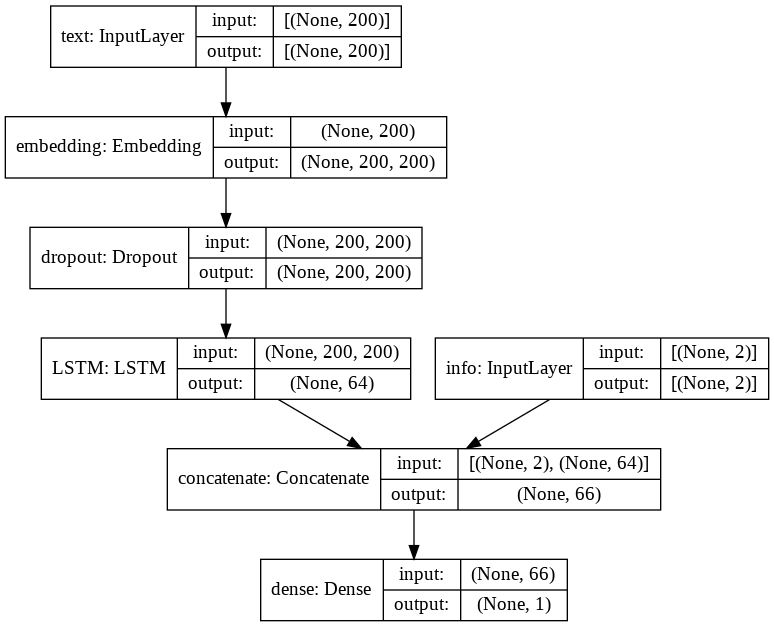

In [24]:
plot_model(model_func, show_shapes=True)

In [26]:
history = model_func.fit(x = {"text": np.array(padded_docs),
            "info": np.array(info_ls)},
            y = np.array(label_ls),
            batch_size = 100,
            epochs = 20, 
            shuffle = True,
            validation_split = 0.2
            )

Epoch 1/20
40/40 [==============================] - 24s 553ms/step - loss: 0.5578 - accuracy: 0.7528 - val_loss: 0.5108 - val_accuracy: 0.7655
Epoch 2/20
40/40 [==============================] - 23s 560ms/step - loss: 0.4556 - accuracy: 0.8224 - val_loss: 0.4658 - val_accuracy: 0.8135
Epoch 3/20
40/40 [==============================] - 22s 546ms/step - loss: 0.4167 - accuracy: 0.8528 - val_loss: 0.4391 - val_accuracy: 0.8247
Epoch 4/20
40/40 [==============================] - 22s 561ms/step - loss: 0.3708 - accuracy: 0.8673 - val_loss: 0.4351 - val_accuracy: 0.8267
Epoch 5/20
40/40 [==============================] - 24s 611ms/step - loss: 0.3419 - accuracy: 0.8862 - val_loss: 0.4298 - val_accuracy: 0.8318
Epoch 6/20
40/40 [==============================] - 22s 544ms/step - loss: 0.3163 - accuracy: 0.8977 - val_loss: 0.4326 - val_accuracy: 0.8328
Epoch 7/20
40/40 [==============================] - 22s 550ms/step - loss: 0.2948 - accuracy: 0.9041 - val_loss: 0.4135 - val_accuracy: 0.8440

In [27]:
history.history

{'accuracy': [0.7528061270713806,
  0.8224489688873291,
  0.8528061509132385,
  0.8673469424247742,
  0.8862245082855225,
  0.8977040648460388,
  0.9040816426277161,
  0.9196428656578064,
  0.925765335559845,
  0.9298469424247742,
  0.9357143044471741,
  0.9443877339363098,
  0.9446428418159485,
  0.9487245082855225,
  0.9520407915115356,
  0.9576530456542969,
  0.9596938490867615,
  0.9581632614135742,
  0.9627550840377808,
  0.9658163189888],
 'loss': [0.5577968955039978,
  0.4556081295013428,
  0.41671332716941833,
  0.3708033561706543,
  0.3419102132320404,
  0.31630852818489075,
  0.2948119044303894,
  0.27126649022102356,
  0.2501654624938965,
  0.24123772978782654,
  0.22630438208580017,
  0.2106086015701294,
  0.20835453271865845,
  0.20050790905952454,
  0.18766231834888458,
  0.1732538342475891,
  0.17520850896835327,
  0.1775110810995102,
  0.1540602147579193,
  0.14563828706741333],
 'val_accuracy': [0.7655453681945801,
  0.8134556412696838,
  0.8246687054634094,
  0.826707

## Making Plot

<Figure size 432x288 with 0 Axes>

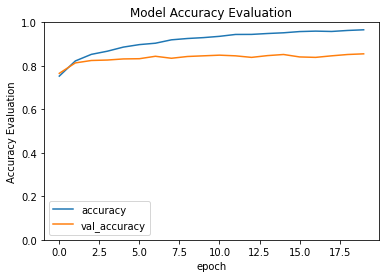

In [28]:
hist_df = pd.DataFrame(history.history)

import matplotlib.pyplot as plt
plt.figure()
acc_df = hist_df[['accuracy', 'val_accuracy']] 

loss_df = hist_df[['loss', 'val_loss']]
# df['loss/10'] = df['loss']/10
# df['val_loss/10'] = df['val_loss']/10
# df1 = df[['accuracy', 'val_accuracy', 'loss/10', 'val_loss/10']]
acc_df.plot()
plt.ylabel('Accuracy Evaluation')
plt.xlabel('epoch')
plt.ylim([0,1])
plt.title("Model Accuracy Evaluation")
plt.show()

<Figure size 432x288 with 0 Axes>

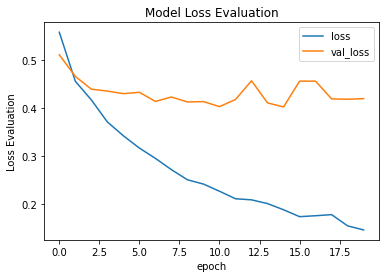

In [30]:
plt.figure()
loss_df.plot()
plt.ylabel('Loss Evaluation')
plt.xlabel('epoch')
plt.title("Model Loss Evaluation")
plt.show()

<Figure size 432x288 with 0 Axes>

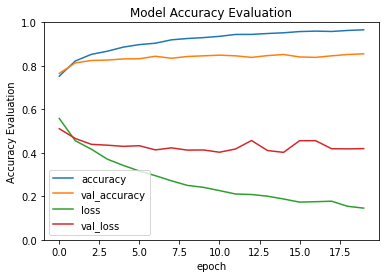

In [29]:
plt.figure()
df = hist_df[['accuracy', 'val_accuracy', 'loss', 'val_loss']]
df.plot()
plt.ylabel('Accuracy Evaluation')
plt.xlabel('epoch')
plt.ylim([0,1])
plt.title("Model Accuracy Evaluation")
plt.show() 